In [89]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output

In [90]:
import os
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import pickle
from collections import defaultdict

from skimage.segmentation import mark_boundaries
from glob import glob
import pandas as pd
import scipy
import cv2
import joblib

from sklearn.model_selection import StratifiedShuffleSplit

In [91]:
import torch
from torch.utils.data.sampler import Sampler
import torch.nn.functional as F

In [92]:
import sys
sys.path.append('../torch_utils/')
sys.path.append('../utils')
sys.path.append('../zoo')
import rles
import dataset as ds
%load_ext autoreload
%autoreload 2
import ternaus_net
%load_ext autoreload
%autoreload 2
import enorm
%load_ext autoreload
%autoreload 2
import augmentations as augs
%load_ext autoreload
%autoreload 2
import learner as lrnr
%load_ext autoreload
%autoreload 2
import torch_funcs as thf
%load_ext autoreload
%autoreload 2
import losses
import metrics
import visualisation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
PATHS = {
    'DATA': '../data/',
    'MASKS': '../data/masks/',
    'ARCHIVE': '../data/indianapolis/',
    'TRAIN': '../data/train',
    'TEST': '../data/test',
    'CSV': '../data/csv',
}

PARAMS = {
    'PATHS': PATHS,
    'SEED': 42,
    'NB_FOLDS': 4,
    'PNG_SIDE': 512,
    'EXP_GAMMA': .9,
    'CUDA_DEVICES': [0, 1],
    'INVERSE': 3,
    'BATCH_SIZE': 24,
    'NB_EPOCHS': 200,
    'LR': 4e-4,
    'EXP_GAMMA': .99,
    'CUDA_DEVICES': [0, 1],
}

In [94]:
CUDA_IDX = 0
torch.cuda.set_device(CUDA_IDX)

In [95]:
mpaths = glob(os.path.join(PATHS['ARCHIVE'], 'masks', '*', '*.png'))
ipaths = glob(os.path.join(PATHS['ARCHIVE'], 'png', '*', '*.png'))

separate = lambda x: os.path.join(os.path.basename(os.path.dirname(x)), os.path.basename(x))
ipaths = [separate(path) for path in ipaths]
mpaths = [separate(path) for path in mpaths]

paths = list(set(mpaths).intersection(ipaths))
paths_df = pd.Series([separate(path) for path in paths], name='ImageId')
paths_df = pd.DataFrame(paths_df)

In [96]:
paths = ds.get_paths(paths_df, root_dir=PATHS['ARCHIVE'])

# stds = []
# means = []
for key, path in tqdm(paths.items()):
    break
    image = cv2.imread(path['image'], 0)
    coeff = PARAMS['PNG_SIDE'] / min(image.shape)
    shape = np.ceil(coeff * np.array(image.shape)).astype(np.int)
    image = cv2.resize(image, tuple(shape[::-1].tolist()), interpolation=cv2.INTER_AREA)
    cv2.imwrite(path['image'], image)

    mask = cv2.imread(path['mask'], 0)
    mask = cv2.resize(mask, tuple(shape[::-1].tolist()), interpolation=cv2.INTER_AREA)
    cv2.imwrite(path['mask'], (mask > 120).astype(np.uint8) * 255)

    for i in range(PARAMS['INVERSE']):
        image = cv2.imread(path['inversed'].format(i + 1), 0)
        image = cv2.resize(image, tuple(shape[::-1].tolist()), interpolation=cv2.INTER_AREA)
        cv2.imwrite(path['inversed'].format(i + 1), image)


  0%|          | 0/424 [00:00<?, ?it/s]


In [97]:
augments = augs.Augmentation(side=512, strength=1.)
dataset = ds.CXR_Dataset(paths, augmentations=augments, inverse=3)

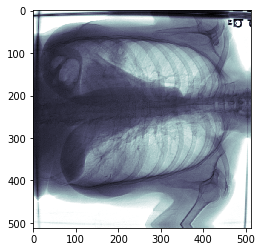

In [98]:
i = np.random.randint(len(dataset))
data = dataset[i]
plt.imshow(data['image'][0], cmap=plt.cm.bone)

In [99]:
def get_datagens(fold, df):
    paths = ds.get_paths(df, root_dir=PATHS['ARCHIVE'])

    paths_fold, paths_rest = ds.get_fold(paths, fold=fold, nb_folds=PARAMS['NB_FOLDS'])
    augments = augs.Augmentation(side=384, strength=1.)
    augments_val = augs.Augmentation(side=512, strength=0)
    dataset_train = ds.CXR_Dataset(paths_rest, augmentations=augments, inverse=PARAMS['INVERSE'])
    dataset_val = ds.CXR_Dataset(paths_fold, augments_val)

    train_datagen = torch.utils.data.DataLoader(dataset_train, pin_memory=False,
                                                batch_size=PARAMS['BATCH_SIZE'],
                                                num_workers=8)
    val_datagen = torch.utils.data.DataLoader(dataset_val,
                                              shuffle=False,
                                              batch_size=PARAMS['BATCH_SIZE'] // 3,
                                              num_workers=0)
    return train_datagen, val_datagen

In [100]:
def orchestrate(learner, train_datagen, val_datagen, 
                fold=0, epochs=1, hard_negative_miner=None,
                checkpoints_pth='../data/', lr_scheduler=None, 
                history=None, verbose=True, nb_freezed_epchs=0):

    if checkpoints_pth is not None:
        path = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}')
    if history is None:
        history = defaultdict(list)
    try:
        os.mkdir(checkpoints_pth)
    except:
        pass
    last_epoch = len(history['train_losses'])
    print('last_epoch: {}'.format(last_epoch))

    for epoch_i in range(last_epoch, epochs):
        if hasattr(lr_scheduler, 'step'):
            lr_scheduler.step()
        learner.freeze_encoder(unfreeze=(epoch_i >= nb_freezed_epchs))

        meters = learner.train_on_epoch(
            train_datagen, 
            hard_negative_miner=hard_negative_miner,
            lr_scheduler=lr_scheduler
        )
        history['train_losses'].append(meters)

        meters = learner.validate(val_datagen)
        history['val_losses'].append(meters)

        clear_output(wait=True)
        if verbose:
            visualisation.plot_losses(history)
            learner.infer_on_data(val_datagen.dataset[2])
            learner.infer_on_data(val_datagen.dataset[0])
#             if train_dataset.aug_params['strength'] > min_strength:
#                 train_dataset.aug_strength_decay(strength_decay)

        if (checkpoints_pth is not None) and ((epoch_i) % 10 == 0):
            state_dict = learner.model.state_dict()
            if isinstance(learner.model, torch.nn.DataParallel):
                state_dict = learner.model.module.state_dict()
            torch.save(state_dict, 
                       path.format(fold, epoch_i))
            pickle.dump(history, open(path.format(fold, 'loss'), 'wb'))
            print(path.format(fold, epoch_i))

#         train_dataset.converge_appearence(decay=converge_appearence)

    return learner, history

In [101]:
loss = losses.BCEDiceJaccardLoss(
    weights={
        'bce': .7,
#         'jacc': .3,
        'dice': .3,
    },
#     chnls_w=np.array([1.] * 5 + [.1])
)

In [102]:
last_epoch = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
}

In [103]:
# ref_energies = np.load('../data/csv/energies.npy')
# enm = enorm.EnergyNormalization()


# def proceed_to_energies(ref_energies, enm, k, v):
#     image = cv2.imread(v['image'], 0).astype(np.float)
#     mask = cv2.imread(v['mask'], 0) > 120

#     lungs_border = image[mask ^ scipy.ndimage.binary_dilation(mask, iterations=100)]
#     if np.median(lungs_border) < np.median(image[mask]):
#         image = -image

#     diffs = list()
#     for i, ref_energy in enumerate(ref_energies):
#         inversed, diff = enm.iterate_normalization_by_energy([image], [mask], ref_energy, verbose=False)
#         inversed = np.squeeze(inversed)
#         inversed = (inversed - inversed.min()) / (inversed.max() - inversed.min())
#         inversed = (inversed * 255.).astype(np.uint8)
#         diffs.append(diff)
#         cv2.imwrite(v['inversed'].format(i + 1), inversed)
#     return diffs


# diffs = joblib.Parallel(n_jobs=7)(joblib.delayed(proceed_to_energies)(ref_energies, enm, k, v) for k, v in tqdm(paths.items()))
# dff = pd.DataFrame(np.array(diffs)[..., 0, :].mean(-1))
# dff.to_csv('../data/csv/indianapolis_diffs.csv', index=False)

In [16]:
image = cv2.imread('../data/indianapolis/png/atherosclerosis/1065_IM-0046-1001.dcm.png', 0).astype(np.float)
image1 = cv2.imread('../data/indianapolis/inversed/1/atherosclerosis/1065_IM-0046-1001.dcm.png', 0)
image2 = cv2.imread('../data/indianapolis/inversed/2/atherosclerosis/1065_IM-0046-1001.dcm.png', 0)
image3 = cv2.imread('../data/indianapolis/inversed/3/atherosclerosis/1065_IM-0046-1001.dcm.png', 0)
mask = cv2.imread('../data/indianapolis/masks/atherosclerosis/1065_IM-0046-1001.dcm.png', 0) > 120

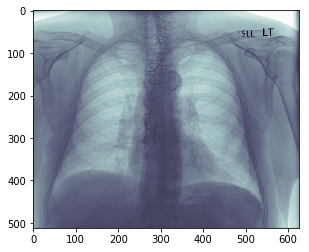

In [17]:
plt.imshow(image, cmap=plt.cm.bone)

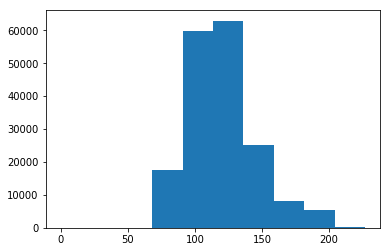

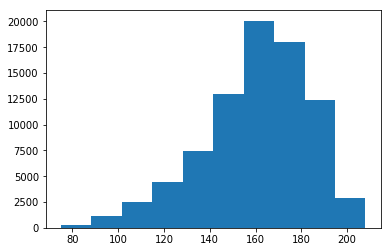

In [18]:
plt.hist(image[mask ^ scipy.ndimage.binary_dilation(mask, iterations=100)]);
plt.show()
plt.hist(image[mask]);

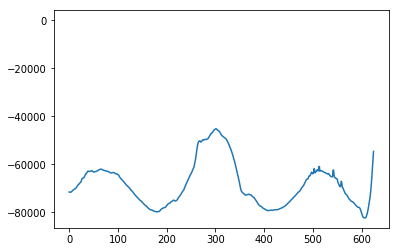

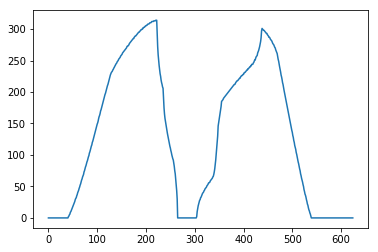

In [19]:
plt.plot(np.arange(image.shape[1]), -image.sum(0), 100);
plt.show()
plt.plot(np.arange(image.shape[1]), mask.sum(0), 100);

# YOUHUU

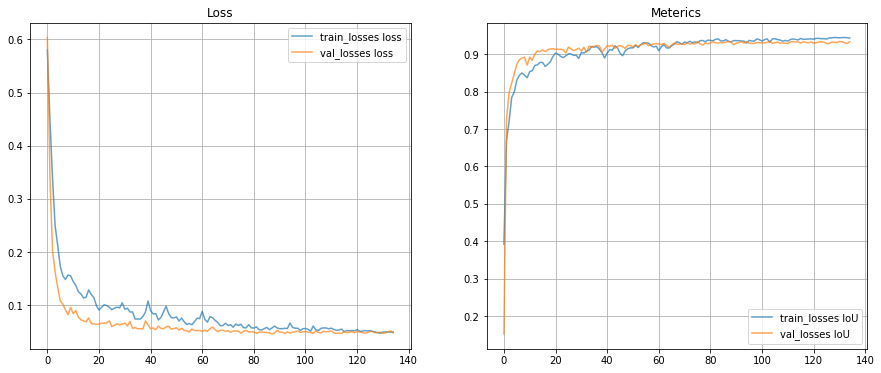

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
fold = 0
train_datagen, val_datagen = get_datagens(fold, paths_df)

checkpoints_pth = '../data/models/albunet_BNdec/'

model = ternaus_net.AlbuNet(pretrained=True, decoder_block=ternaus_net.UnetBNDecoderBlock, single_channel=True)
checkpoints = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}')
model = thf.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=PARAMS['LR'])
learner = lrnr.Learner(model=model, opt=opt, loss=loss, metrics=[metrics.IoU(threshold=.5)])

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(learner.opt, gamma=PARAMS['EXP_GAMMA'], last_epoch=last_epoch[fold])

learner, _ = orchestrate(
    learner=learner, train_datagen=train_datagen, val_datagen=val_datagen, epochs=PARAMS['NB_EPOCHS'],
    lr_scheduler=lr_scheduler, fold=fold, checkpoints_pth='../data/models/albunet_BNdec',
    history=None, nb_freezed_epchs=2
)

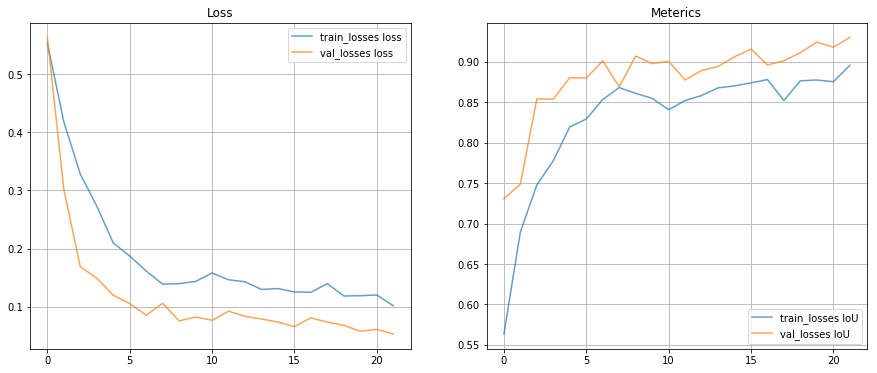

In [ ]:
fold = 1
train_datagen, val_datagen = get_datagens(fold, paths_df)

checkpoints_pth = '../data/models/albunet_BNdec/'

model = ternaus_net.AlbuNet(pretrained=True, decoder_block=ternaus_net.UnetBNDecoderBlock, single_channel=True)
checkpoints = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}')
model = thf.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=PARAMS['LR'])
learner = lrnr.Learner(model=model, opt=opt, loss=loss, metrics=[metrics.IoU(threshold=.5)])

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(learner.opt, gamma=PARAMS['EXP_GAMMA'], last_epoch=last_epoch[fold])

learner, _ = orchestrate(
    learner=learner, train_datagen=train_datagen, val_datagen=val_datagen, epochs=PARAMS['NB_EPOCHS'],
    lr_scheduler=lr_scheduler, fold=fold, checkpoints_pth='../data/models/albunet_BNdec',
    history=None, nb_freezed_epchs=2
)

In [ ]:
fold = 2
train_datagen, val_datagen = get_datagens(fold, paths_df)

checkpoints_pth = '../data/models/albunet_BNdec/'

model = ternaus_net.AlbuNet(pretrained=True, decoder_block=ternaus_net.UnetBNDecoderBlock, single_channel=True)
checkpoints = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}')
model = thf.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=PARAMS['LR'])
learner = lrnr.Learner(model=model, opt=opt, loss=loss, metrics=[metrics.IoU(threshold=.5)])

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(learner.opt, gamma=PARAMS['EXP_GAMMA'], last_epoch=last_epoch[fold])

learner, _ = orchestrate(
    learner=learner, train_datagen=train_datagen, val_datagen=val_datagen, epochs=PARAMS['NB_EPOCHS'],
    lr_scheduler=lr_scheduler, fold=fold, checkpoints_pth='../data/models/albunet_BNdec',
    history=None, nb_freezed_epchs=2
)

In [ ]:
fold = 3
train_datagen, val_datagen = get_datagens(fold, paths_df)

checkpoints_pth = '../data/models/albunet_BNdec/'

model = ternaus_net.AlbuNet(pretrained=True, decoder_block=ternaus_net.UnetBNDecoderBlock, single_channel=True)
checkpoints = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}')
model = thf.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=PARAMS['LR'])
learner = lrnr.Learner(model=model, opt=opt, loss=loss, metrics=[metrics.IoU(threshold=.5)])

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(learner.opt, gamma=PARAMS['EXP_GAMMA'], last_epoch=last_epoch[fold])

learner, _ = orchestrate(
    learner=learner, train_datagen=train_datagen, val_datagen=val_datagen, epochs=PARAMS['NB_EPOCHS'],
    lr_scheduler=lr_scheduler, fold=fold, checkpoints_pth='../data/models/albunet_BNdec',
    history=None, nb_freezed_epchs=2
)

In [41]:
val_datagen.dataset.inverse = 3

/home/vessemer/anaconda3/envs/cxr/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


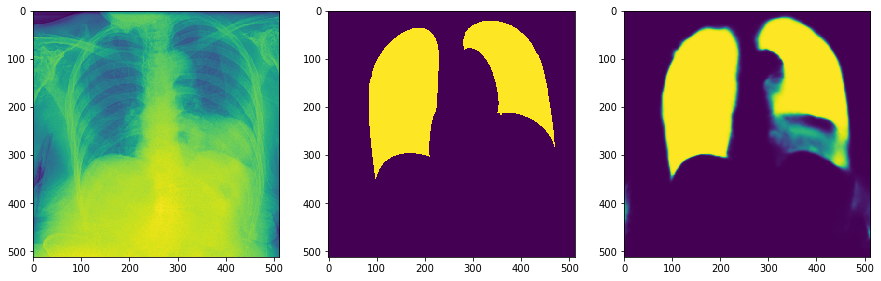

In [52]:
# i = np.random.randint(len(val_datagen.dataset))
data = val_datagen.dataset[i]
data['image'] = data['image']
learner.infer_on_data(data, verbose=True);

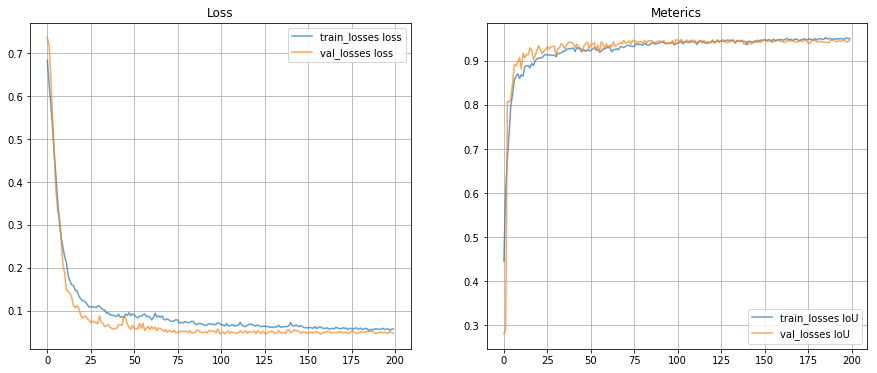

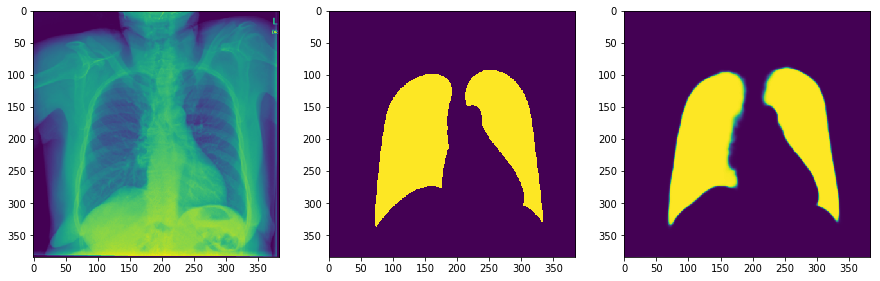

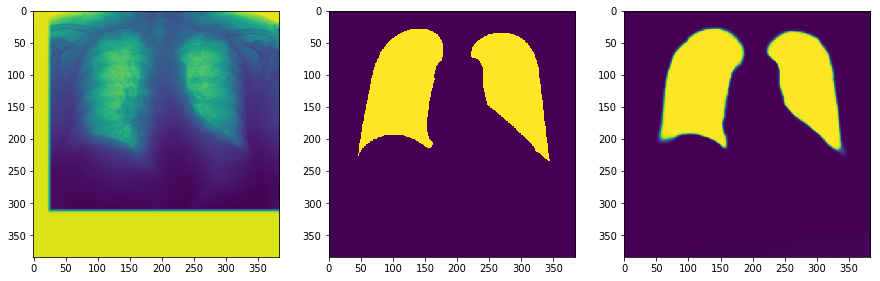

In [24]:
fold = 1
train_datagen, val_datagen = get_datagens(fold, paths_df)

checkpoints_pth = '../data/models/albunet_BNdec/'

model = ternaus_net.AlbuNet(pretrained=True, decoder_block=ternaus_net.UnetBNDecoderBlock, single_channel=True)
checkpoints = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}')
model = thf.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=PARAMS['LR'])
learner = lrnr.Learner(model=model, opt=opt, loss=loss, metrics=[metrics.IoU(threshold=.5)])

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(learner.opt, gamma=PARAMS['EXP_GAMMA'], last_epoch=last_epoch[fold])

learner, _ = orchestrate(
    learner=learner, train_datagen=train_datagen, val_datagen=val_datagen, epochs=PARAMS['NB_EPOCHS'],
    lr_scheduler=lr_scheduler, fold=fold, checkpoints_pth='../data/models/albunet_BNdec',
    history=None, nb_freezed_epchs=2
)

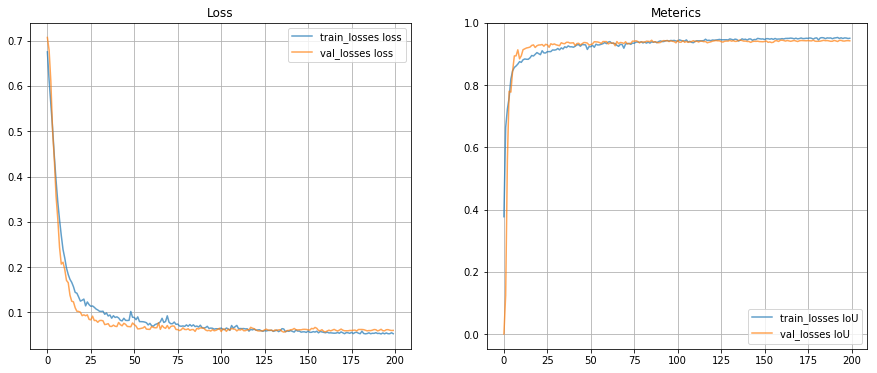

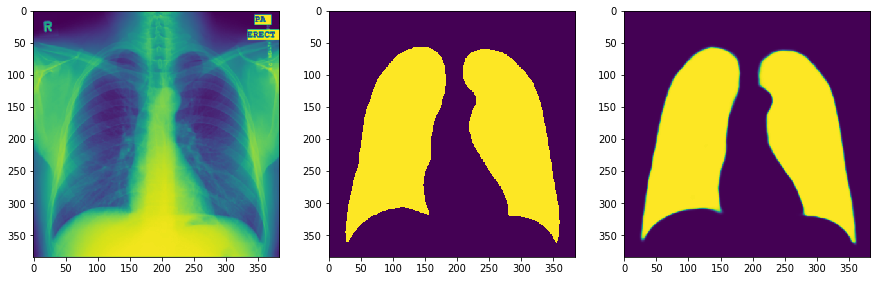

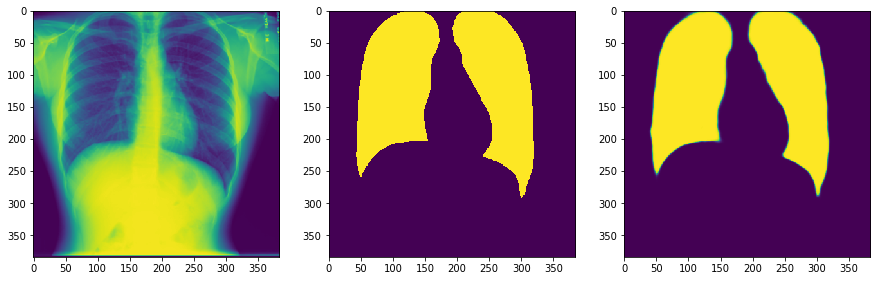

In [25]:
fold = 2
train_datagen, val_datagen = get_datagens(fold, paths_df)

checkpoints_pth = '../data/models/albunet_BNdec/'

model = ternaus_net.AlbuNet(pretrained=True, decoder_block=ternaus_net.UnetBNDecoderBlock, single_channel=True)
checkpoints = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}')
model = thf.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=PARAMS['LR'])
learner = lrnr.Learner(model=model, opt=opt, loss=loss, metrics=[metrics.IoU(threshold=.5)])

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(learner.opt, gamma=PARAMS['EXP_GAMMA'], last_epoch=last_epoch[fold])

learner, _ = orchestrate(
    learner=learner, train_datagen=train_datagen, val_datagen=val_datagen, epochs=PARAMS['NB_EPOCHS'],
    lr_scheduler=lr_scheduler, fold=fold, checkpoints_pth='../data/models/albunet_BNdec',
    history=None, nb_freezed_epchs=2
)

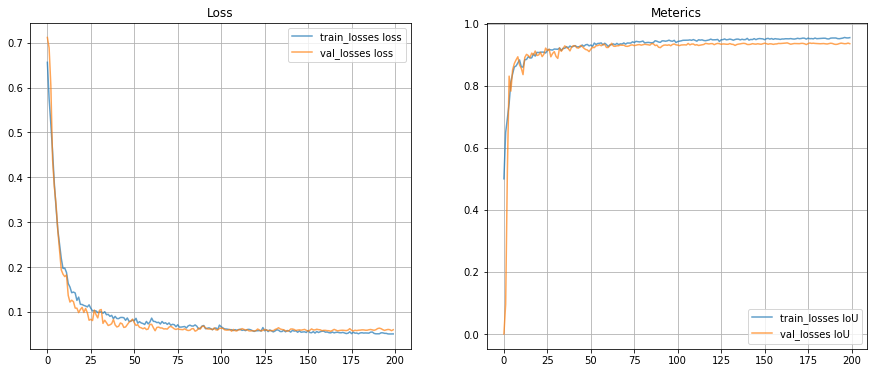

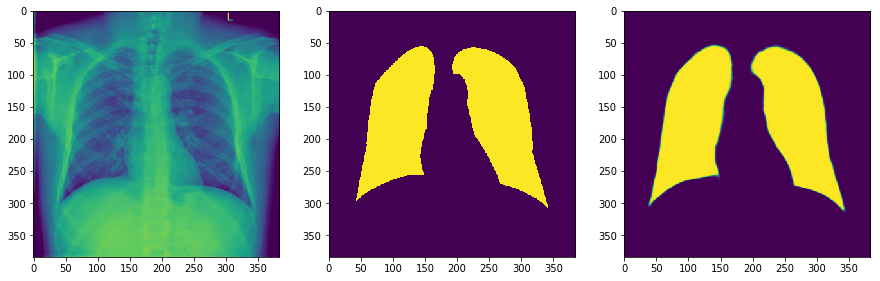

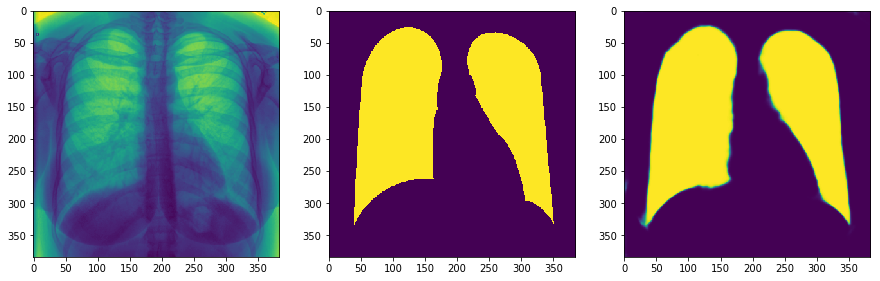

In [26]:
fold = 3
train_datagen, val_datagen = get_datagens(fold, paths_df)

checkpoints_pth = '../data/models/albunet_BNdec/'

model = ternaus_net.AlbuNet(pretrained=True, decoder_block=ternaus_net.UnetBNDecoderBlock, single_channel=True)
checkpoints = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}')
model = thf.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])

opt = torch.optim.Adam(model.parameters(), lr=PARAMS['LR'])
learner = lrnr.Learner(model=model, opt=opt, loss=loss, metrics=[metrics.IoU(threshold=.5)])

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(learner.opt, gamma=PARAMS['EXP_GAMMA'], last_epoch=last_epoch[fold])

learner, _ = orchestrate(
    learner=learner, train_datagen=train_datagen, val_datagen=val_datagen, epochs=PARAMS['NB_EPOCHS'],
    lr_scheduler=lr_scheduler, fold=fold, checkpoints_pth='../data/models/albunet_BNdec',
    history=None, nb_freezed_epchs=2
)

# Inference over dataset

In [105]:
import joblib

In [106]:
idir = os.path.join(PATHS['TRAIN'])
mdir = os.path.join(PATHS['TRAIN'], 'masks')
paths = glob(os.path.join(idir, 'png', '*.png'))
paths = [os.path.basename(path) for path in paths]
paths_df = pd.Series([separate(path) for path in paths], name='ImageId')
paths_df = pd.DataFrame(paths_df)

In [107]:
aug = lambda x: { k: cv2.resize(v, (256, 256)) for k, v in x.items() if v is not None}

In [108]:
paths = ds.get_paths(paths_df, root_dir=idir)
dataset = ds.CXR_Dataset(paths, augmentations=aug)
datagen = torch.utils.data.DataLoader(dataset,
                                      shuffle=False,
                                      batch_size=1,
                                      num_workers=0)

In [59]:
def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return np.array(mirrs)


def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return origs

In [16]:
# plt.imshow((image[0, ..., 0] - ds.MEAN) / ds.STD)

In [60]:
last_iter = 190
checkpoints_pth = '../data/models/albunet_BNdec/'
checkpoints = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}')

cnn_pool = list()
for fold in range(4):
    model = ternaus_net.AlbuNet(pretrained=True, decoder_block=ternaus_net.UnetBNDecoderBlock, single_channel=True)
    model = thf.get_model(model, checkpoint=checkpoints.format(fold, last_iter), devices=PARAMS['CUDA_DEVICES'])
    model.module.eval()
    cnn_pool.append(model)


Overlapped keys: 480
Overlapped keys: 480
Overlapped keys: 480
Overlapped keys: 480


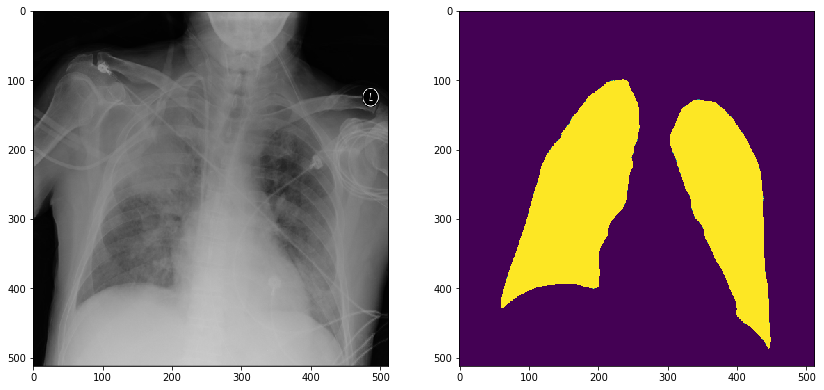

10086it [3:14:21,  1.16s/it]

In [ ]:
for i, (k, v) in tqdm(enumerate(paths.items())):
    image = cv2.imread(v['image'])
    image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_AREA)
    image1 = ((255. - image[..., :1].astype(np.float)) / 255. - ds.MEAN) / ds.STD
    image2 = (image[..., :1] / 255. - ds.MEAN) / ds.STD
    images1 = _rotate_mirror_do(image1)
    images2 = _rotate_mirror_do(image2)
    images = np.concatenate([images1, images2])
    images = torch.tensor(np.rollaxis(images.astype(np.float32), 3, 1))

    with torch.no_grad():
        preds_ = list()
        images = torch.autograd.Variable(images).cuda()
        for cnn in cnn_pool:
            pred = torch.sigmoid(cnn(images))
            preds_.append(pred.data.cpu().numpy())

    preds = list()
    for pred in preds_:
        preds += _rotate_mirror_undo(np.rollaxis(pred[:8], 1, 4))
        preds += _rotate_mirror_undo(np.rollaxis(pred[8:], 1, 4))

    pred = 255 * np.median(np.array(preds) > .5, axis=0).squeeze()
    cv2.imwrite(os.path.join(mdir, k), pred.astype(np.uint8))

    if i % 100 == 0:
        clear_output()
        _, ax = plt.subplots(ncols=2, figsize=(14, 7))
        ax[0].imshow(np.squeeze(image))
        ax[1].imshow(np.squeeze(pred))
        plt.show()


In [ ]:
1

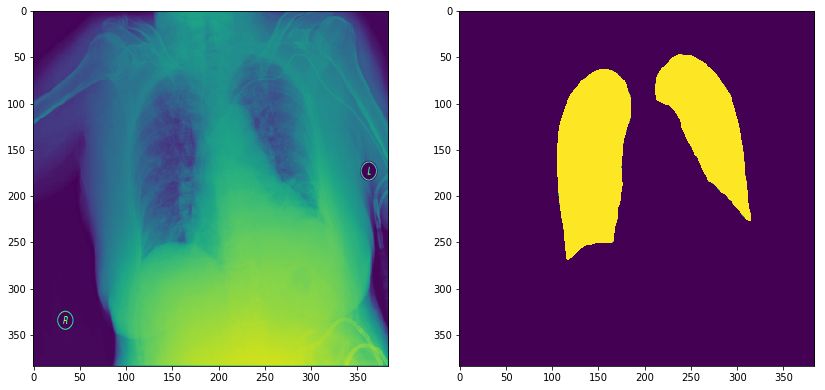

25684it [2:07:43,  3.35it/s]


In [40]:
for i, (k, v) in tqdm(enumerate(paths.items())):
    image = cv2.imread(v['image'])
    image = cv2.resize(image, (384, 384), interpolation=cv2.INTER_AREA)
    image = (image[..., :1] / 255. - ds.MEAN) / ds.STD
    images = _rotate_mirror_do(image)
    images = torch.tensor(np.rollaxis(images.astype(np.float32), 3, 1))

    with torch.no_grad():
        preds_ = list()
        images = torch.autograd.Variable(images).cuda()
        for cnn in cnn_pool:
            pred = torch.sigmoid(cnn(images))
            preds_.append(pred.data.cpu().numpy())

    preds = list()
    for pred in preds_:
        preds += _rotate_mirror_undo(np.rollaxis(pred, 1, 4))

    pred = 255 * np.median(np.array(preds) > .5, axis=0).squeeze()
    cv2.imwrite(os.path.join(mdir, k), pred.astype(np.uint8))

    if i % 100 == 0:
        clear_output()
        _, ax = plt.subplots(ncols=2, figsize=(14, 7))
        ax[0].imshow(np.squeeze(image))
        ax[1].imshow(np.squeeze(pred))
        plt.show()


In [16]:
enm = enorm.EnergyNormalization(B=PARAMS['ENERGY_B'], alpha=2, gamma=2)

In [17]:
def get_energies(enm, pid, path):
    image = cv2.imread(path['image'], 0).astype(np.float32)
    mask = cv2.imread(path['mask'], 0)
    mask = cv2.resize(mask, image.shape) > 120

    decompose = enm.decompose([image])
    energies = enm.get_energies(decompose, [mask])[0]

    return (pid, *energies)

In [51]:
# for k, v in tqdm(paths.items()):
#     image = cv2.imread(v['image'], 0).astype(np.float32)
#     mask = cv2.imread(v['mask'], 0)
#     mask = cv2.resize(mask, image.shape) > 120

#     decompose = enm.decompose([image])
#     energies = enm.get_energies(decompose, [mask])
#     paths[k].update({'energies': energies})

#     pth = os.path.join(
#         os.path.dirname(idir), 
#         'npz', 
#         os.path.basename(v['image'])
#     )
#     np.save(pth[:-4], np.array(decompose)[0])
#     break

In [17]:
test_energies_df = pd.read_csv('../data/csv/stage_1_test_energies.csv').drop('Unnamed: 0', axis=1)
train_energies_df = pd.read_csv('../data/csv/stage_1_train_energies.csv').drop('Unnamed: 0', axis=1)

In [33]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN


values = train_energies_df.drop(['ImageId'], axis=1).dropna().values
values = (values - values.mean(axis=0)) / values.std(axis=0)
pca = PCA(n_components=1)
pcaid = pca.fit_transform(X=values[:, :-1])
energy_features = np.concatenate([pcaid, values[:, -1:]], axis=1)
# kmeans = KMeans(n_clusters=2)
# labels_ = kmeans.fit_predict(energy_features)

tsne = TSNE()
energy_features = tsne.fit_transform(values)
a = DBSCAN(eps=5, min_samples=100)
labels = a.fit_predict(energy_features)

In [20]:
train_energies_df[train_energies_df.isna()['Level_0']]

Unnamed: 0                                       ImageId  Level_0  \
3736        3736  4068843a-d393-45cb-9d08-567238cdc6d2.dcm.png      NaN   

      Level_1  Level_2  Level_3  Level_4  Level_5  Level_6  Level_7  
3736      NaN      NaN      NaN      NaN      NaN      NaN      NaN

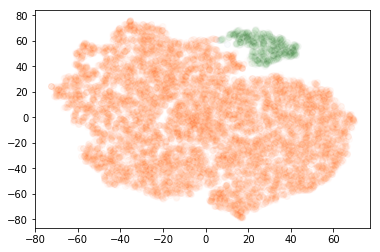

In [34]:
for label in np.unique(labels):
    plt.scatter(energy_features[labels==label, 0], energy_features[labels==label, -1], alpha=.01)

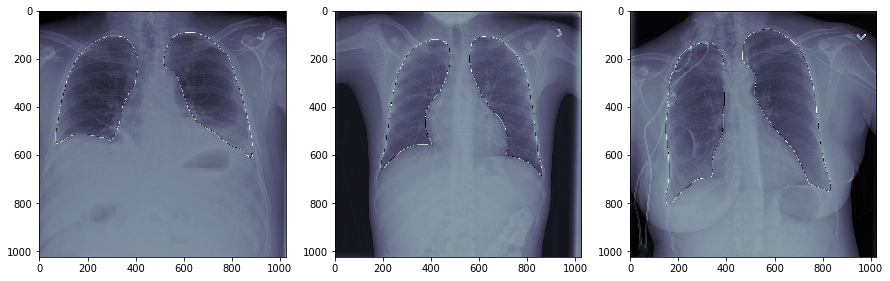

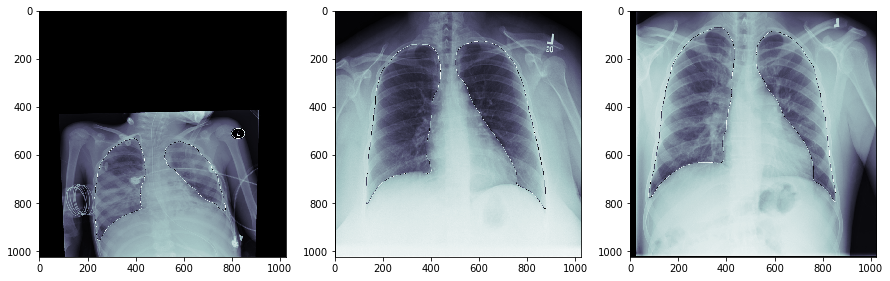

In [35]:
pids1 = np.random.choice(train_energies_df.dropna()[labels == 1].ImageId, size=3)
_, ax = plt.subplots(ncols=3, figsize=(15, 5))
for i, pid in enumerate(pids1):
    image = cv2.imread(os.path.join(idir, pid), 0)
    mask = cv2.imread(os.path.join(mdir, pid), 0)
    mask = cv2.resize(mask, image.shape)
    ax[i].imshow(np.squeeze(image) + mask, cmap=plt.cm.bone)
plt.show()

pids2 = np.random.choice(train_energies_df.dropna()[labels == 0].ImageId, size=3)
_, ax = plt.subplots(ncols=3, figsize=(15, 5))
for i, pid in enumerate(pids2):
    image = cv2.imread(os.path.join(idir, pid), 0)
    mask = cv2.imread(os.path.join(mdir, pid), 0)
    mask = cv2.resize(mask, image.shape)
    ax[i].imshow(np.squeeze(image) + mask, cmap=plt.cm.bone)
plt.show()

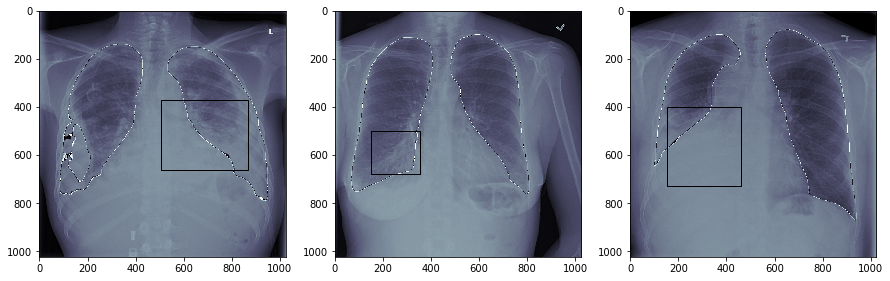

In [24]:
train_df = pd.read_csv('../data/csv/stage_1_train_labels.csv').dropna()
energy_features
pids1 = train_energies_df.dropna()[labels == 1][['ImageId']]
pids1['patientId'] = pids1['ImageId'].apply(lambda x: x.split('.')[0])
pids1_ = pd.merge(train_df, pids1, on='patientId').dropna()
pids1 = np.random.choice(pids1_.ImageId, size=3)

_, ax = plt.subplots(ncols=3, figsize=(15, 5))
for i, pid in enumerate(pids1):
    image = cv2.imread(os.path.join(idir, pid), 0)
    mask = cv2.imread(os.path.join(mdir, pid), 0)
    mask = cv2.resize(mask, image.shape)
    ax[i].imshow(np.squeeze(image) + mask, cmap=plt.cm.bone)
    bboxes = pids1_.query('ImageId==@pid')
    for j, bbox in bboxes.iterrows():
        ax[i].add_patch(
         patches.Rectangle(
            (bbox.x, bbox.y),
            bbox.width,
            bbox.height,
            fill=False
         ))
plt.show()

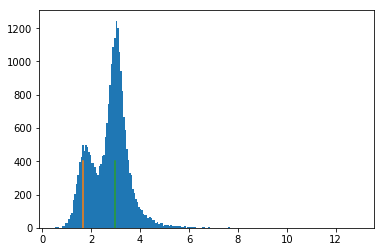

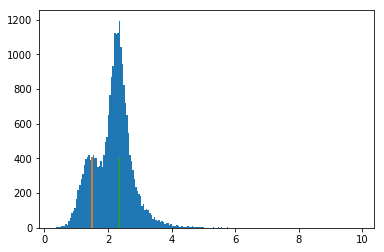

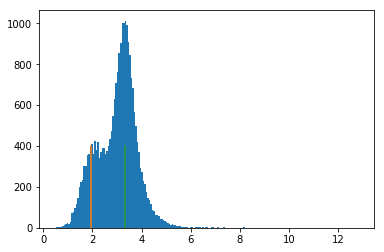

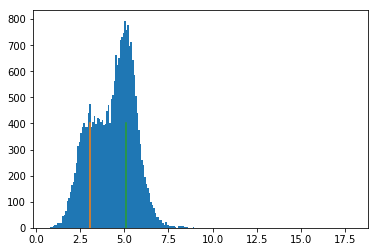

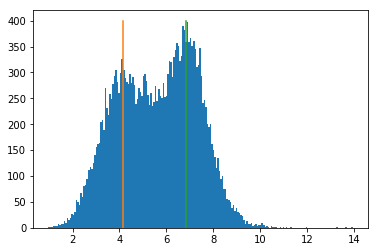

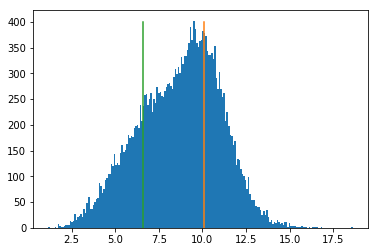

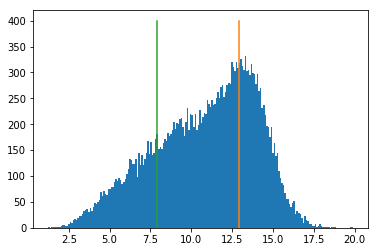

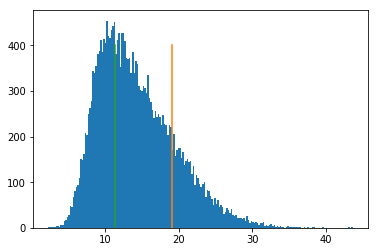

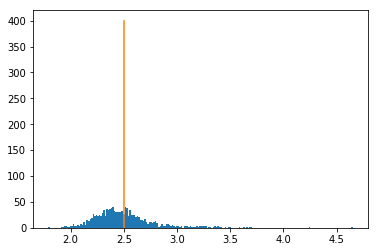

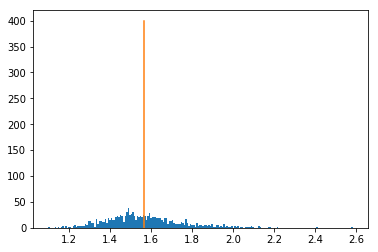

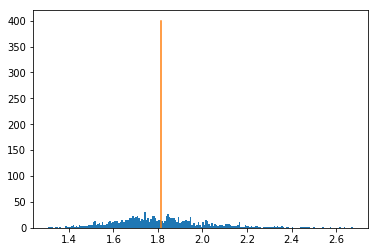

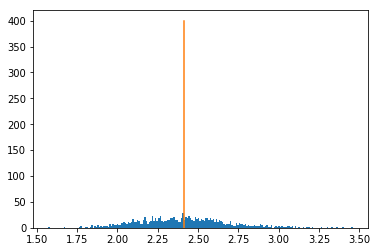

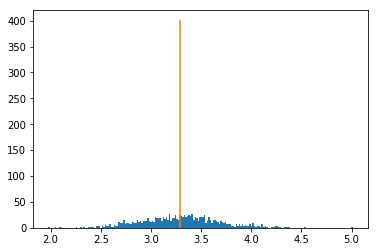

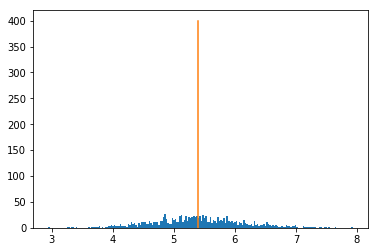

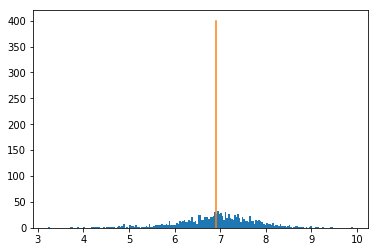

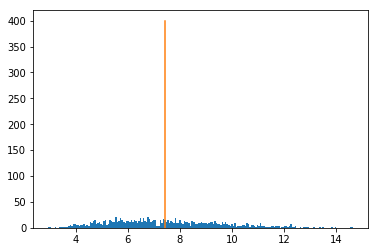

In [160]:
from sklearn.mixture import GaussianMixture

gparams = [
    {
        'label': 0,
        'n_components': 2
    },
    {
        'label': 1,
        'n_components': 1
    },
]
energies = list()
for gparam in gparams:
    subs = np.zeros((8, gparam['n_components']))
    for i in range(8):
        gmm = GaussianMixture(n_components=gparam['n_components'], covariance_type='diag')
        values = train_energies_df.drop(['ImageId'], axis=1).dropna().values
        plt.hist(values[labels == gparam['label']][:, i], 200);

        gmm.fit(values[labels == gparam['label']][:, i: i + 1])
        for e, gmean in enumerate(gmm.means_):
            plt.plot([gmean, gmean], [0, 400])
            subs[i, e] = gmean
        plt.show()
    energies.append(subs)

In [36]:
pids1 = np.random.choice(train_energies_df.dropna()[labels == 0][gpreds == 0].ImageId, size=3)
_, ax = plt.subplots(ncols=3, figsize=(15, 5))
for i, pid in enumerate(pids1):
    image = cv2.imread(os.path.join(idir, pid), 0)
    mask = cv2.imread(os.path.join(mdir, pid), 0)
    mask = cv2.resize(mask, image.shape)
    ax[i].imshow(np.squeeze(image) + mask, cmap=plt.cm.bone)
plt.show()

pids2 = np.random.choice(train_energies_df.dropna()[labels == 0][gpreds == 1].ImageId, size=3)
_, ax = plt.subplots(ncols=3, figsize=(15, 5))
for i, pid in enumerate(pids2):
    image = cv2.imread(os.path.join(idir, pid), 0)
    mask = cv2.imread(os.path.join(mdir, pid), 0)
    mask = cv2.resize(mask, image.shape)
    ax[i].imshow(np.squeeze(image) + mask, cmap=plt.cm.bone)
plt.show()

NameError: name 'gpreds' is not defined

In [161]:
energies = [energies[0][:, 0], energies[0][:, 1], energies[1][:, 0]]

In [172]:
image1 = cv2.imread(os.path.join(idir, pids1[-1]), 0).astype(np.float32)
image2 = cv2.imread(os.path.join(idir, pids2[-1]), 0).astype(np.float32)
mask1 = cv2.imread(os.path.join(mdir, pids1[-1]), 0)
mask1 = cv2.resize(mask1, image1.shape) > 120
mask2 = cv2.imread(os.path.join(mdir, pids2[-1]), 0)
mask2 = cv2.resize(mask2, image2.shape) > 120



In [37]:
# np.save('../data/csv/energies.npy', np.array(energies))
energies = np.load('../data/csv/energies.npy')

In [38]:
'8af89b60-74e2-4f60-8764-b954598cddc4.dcm.png',
'0f0a1877-3f44-42f0-8905-2856078ff2ac.dcm.png',
'70d7f4df-5497-4205-a36b-e47b58145fa2.dcm.png',
'be35c13b-705d-4466-ae3f-ed690080ac9d.dcm.png',
'6438d645-6fdb-4fda-8598-a4c1902a33c2.dcm.png',

('6438d645-6fdb-4fda-8598-a4c1902a33c2.dcm.png',)

In [53]:
class Enorm:
    """Normalize images via localized energy-based method.
    Args:
        ref_energies (list (list (float))): 
        p (float [0, 1]):
    Targets:
        image, mask
    Image types:
        uint8, float32
    """
    def __init__(self, ref_energies, p=1.0):
        self.ref_energies = ref_energies
        self.enm = enorm.EnergyNormalization()

    def augment_image(self, image, mask=None):
        if mask is None:
            mask = np.ones_like(image)

        decomposed = self.enm.decompose([image])
        energy = self.ref_energies[np.random.randint(len(self.ref_energies))]
        image, diff = self.enm.normalize_by_energy(decomposed, [mask], energy)

        return image[0]

    def apply(self, image, mask=None, **params):
        return self.augment_image(image, mask)

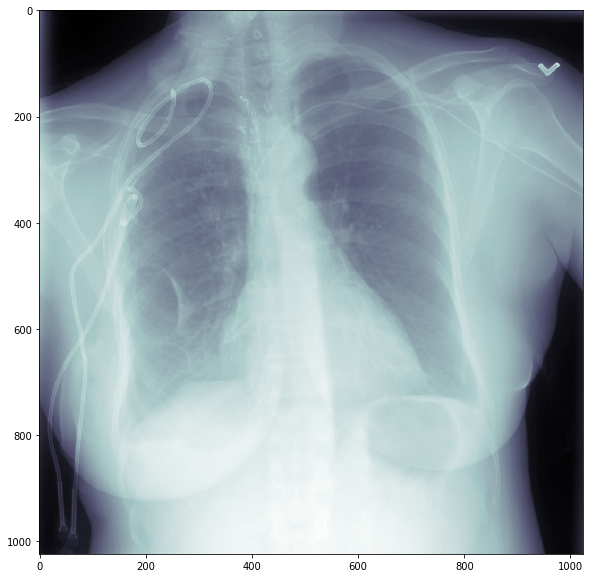

In [78]:
enma = Enorm(energies)
image = enma.apply(image1, mask1)
plt.figure(figsize=(10, 10))
plt.imshow(((image - image.min()) / (image.max() - image.min()) * 255.).astype(np.uint), cmap=plt.cm.bone)
# plt.imshow(image1, cmap=plt.cm.bone)

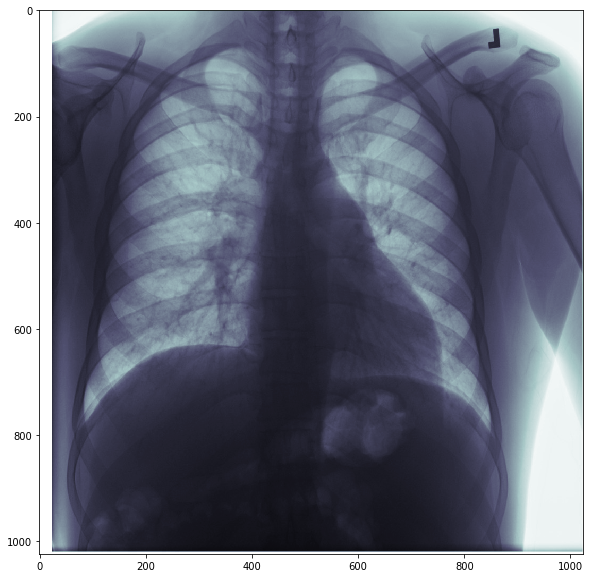

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image2, cmap=plt.cm.bone)

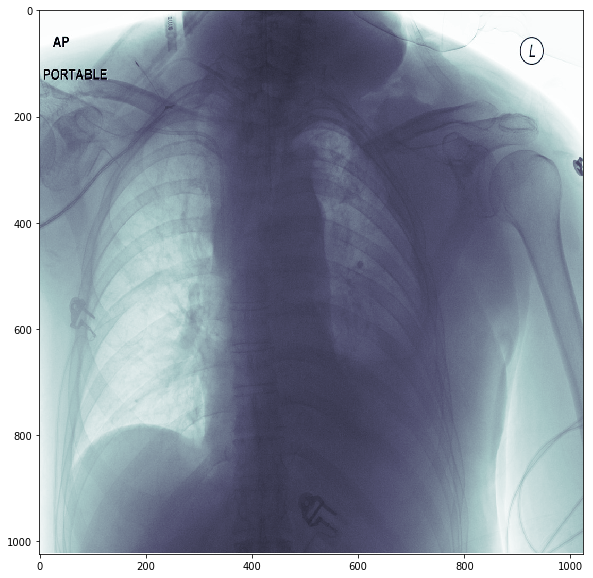

In [177]:
plt.figure(figsize=(10, 10))
plt.imshow(-image1, cmap=plt.cm.bone)

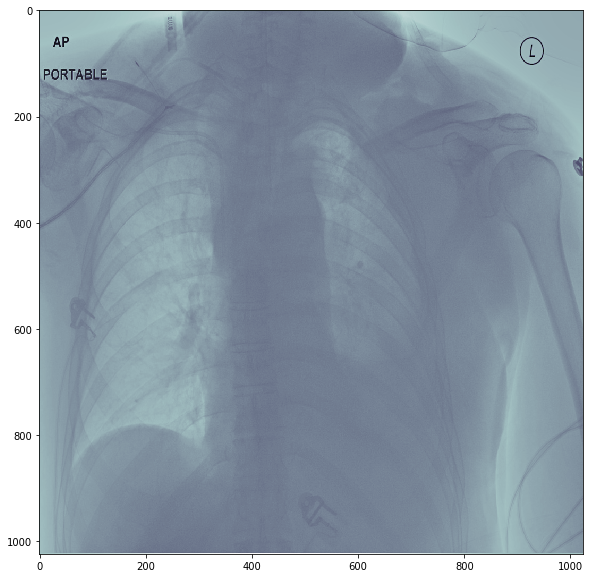

In [176]:
plt.figure(figsize=(10, 10))
plt.imshow(-image[0], cmap=plt.cm.bone)

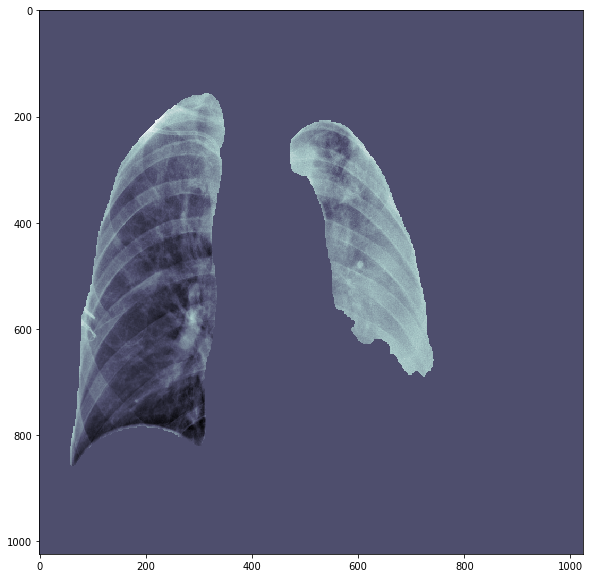

In [168]:
plt.figure(figsize=(10, 10))
alpha = 1
plt.imshow((alpha * image[0] * mask1 + (1 - alpha) * image1 * mask1), cmap=plt.cm.bone)

In [50]:
enm = enorm.EnergyNormalization()
image1 = cv2.imread(os.path.join(idir, pids1[-1]), 0).astype(np.float32)
image2 = cv2.imread(os.path.join(idir, pids2[-1]), 0).astype(np.float32)
mask1 = cv2.imread(os.path.join(mdir, pids1[-1]), 0)
mask1 = cv2.resize(mask1, image1.shape) > 120
mask2 = cv2.imread(os.path.join(mdir, pids2[-1]), 0)
mask2 = cv2.resize(mask2, image2.shape) > 120

image = enm.iterate_normalization([image1], [mask1], [image2], [mask2])

Step:  0 , diff:  1.6812199
Step:  1 , diff:  1.003184195197003
Step:  2 , diff:  0.9982029553034281
Step:  3 , diff:  0.9986448956103195
Step:  4 , diff:  0.9992328278979821
Step:  5 , diff:  0.9996027140643238
Step:  6 , diff:  0.9998079854151246
Step:  7 , diff:  0.999907592371679
Step:  8 , diff:  0.9999432570222817
Step:  9 , diff:  0.999942959209405


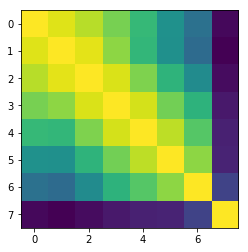

In [81]:
plt.imshow(test_energies_df.drop(['ImageId'], axis=1).corr().values)

In [ ]:
idir = os.path.join(PATHS['TEST'], 'png')
mdir = os.path.join(PATHS['TEST'], 'masks')
paths = glob(os.path.join(idir, '*.png'))
paths = [os.path.basename(path) for path in paths]
paths_df = pd.Series([separate(path) for path in paths], name='ImageId')
paths_df = pd.DataFrame(paths_df)
paths = ds.get_paths(paths_df, imgs_dir=idir, masks_dir=mdir)

test_energies = joblib.Parallel(n_jobs=4)(joblib.delayed(get_energies)(enm, pid, path) for pid, path in tqdm(paths.items()))
test_energies_df = pd.DataFrame(test_energies, columns=['ImageId'] + ['Level_{}'.format(i) for i in range(PARAMS['ENERGY_B'] + 1)])
test_energies_df.to_csv('../data/csv/stage_1_test_energies.csv')

In [74]:
idir = os.path.join(PATHS['TRAIN'], 'png')
mdir = os.path.join(PATHS['TRAIN'], 'masks')
paths = glob(os.path.join(idir, '*.png'))
paths = [os.path.basename(path) for path in paths]
paths_df = pd.Series([separate(path) for path in paths], name='ImageId')
paths_df = pd.DataFrame(paths_df)
paths = ds.get_paths(paths_df, imgs_dir=idir, masks_dir=mdir)


train_energies = joblib.Parallel(n_jobs=4)(joblib.delayed(get_energies)(enm, pid, path) for pid, path in tqdm(paths.items()))
train_energies_df = pd.DataFrame(train_energies, columns=['ImageId'] + ['Level_{}'.format(i) for i in range(PARAMS['ENERGY_B'] + 1)])
train_energies_df.to_csv('../data/csv/stage_1_train_energies.csv')